## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [168]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [169]:
df = pd.read_pickle('LCOResponseData35.pkl')
df['Locked'] = pd.Categorical((df['k_fwt']>0).map({True:"Locked",False:"Free"}))
df['Gust Period'] = pd.Categorical(df['Gust Period'].round(1))
df['Gust Length'] = pd.Categorical(df.apply(lambda row: row['V']*row['Gust Period'],1).round())

model_names = {0:'Full Model',1:'No ZFR',2:'No Force Rot',3:'No Stall',
               4:'SAM',5:'LIN',6:'Full Model, lin 0',7:'No ZFR, Lin 0'}

In [170]:
df.head()

,t,q,Gust Strength,Gust Period,V,alpha_r,delta_m,c_dmax,k_fwt,Lambda,...,Attitude,Delta WRBM,WRBM Max,WRBM Min,WRBM,Inner Tip Deflection,Fold Angle,Lift,Locked,Gust Length
0,0.00,"[3.973491305611813e-05, 0.0, 0.184984087586179...",0,1,35.0,0.069813,1.0,1.0,0.0,0.305433,...,0,0.000000,0.139488,-0.092828,3.614589e+06,126.087112,5.863527,59.526588,Free,35.0
1,0.01,"[3.973491305611814e-05, 1.2843158609303604e-18...",0,1,35.0,0.069813,1.0,1.0,0.0,0.305433,...,0,0.000018,0.139488,-0.092828,3.614589e+06,126.087112,5.863527,59.526588,Free,35.0
2,0.02,"[3.9734913056117756e-05, -4.1330316563397275e-...",0,1,35.0,0.069813,1.0,1.0,0.0,0.305433,...,0,-0.000247,0.139488,-0.092828,3.614589e+06,126.087112,5.863527,59.526588,Free,35.0
3,0.03,"[3.973491305611955e-05, 2.3138554477187288e-15...",0,1,35.0,0.069813,1.0,1.0,0.0,0.305433,...,0,0.000855,0.139488,-0.092828,3.614589e+06,126.087113,5.863527,59.526588,Free,35.0
4,0.04,"[3.973491305611405e-05, -6.029405930689629e-15...",0,1,35.0,0.069813,1.0,1.0,0.0,0.305433,...,0,-0.002486,0.139488,-0.092828,3.614589e+06,126.087110,5.863527,59.526588,Free,35.0


In [171]:
def GetReducedDataSet(df,model_num = None,Config = None,GustPeriod=None,AoA=None,FWT_mass = None,c_dmax = None,V=None,Modes=None,Stable=None,Locked = None):
    data = df.copy()
    data = data[cpo.SeriesFilter(data['Model'],model_num)]
    #data = data[cpo.SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[cpo.SeriesFilter(data['Gust Period'],GustPeriod)]
    data = data[cpo.SeriesFilter(data['Config'],Config)]
    data = data[cpo.SeriesFilter(data['V'],V)]
    data = data[cpo.SeriesFilter(data['c_dmax'],c_dmax)]
    data = data[cpo.SeriesFilter(data['Locked'],Locked)]
    return data

array([35.])

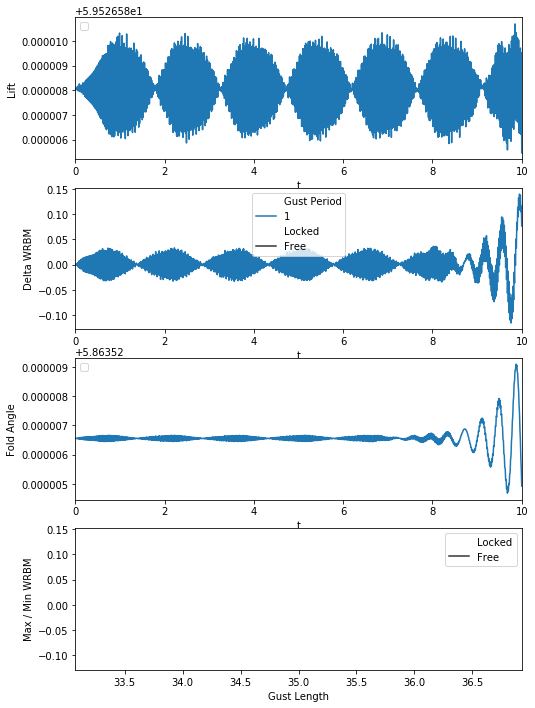

In [172]:
# compare locked and free for a given model
model = [3]
periods = [0.2,0.4,0.8,1.5,2,3]
data = GetReducedDataSet(df,model_num = model,GustPeriod=None,Config =['WT'])
datav2 = GetReducedDataSet(df,model_num = model,GustPeriod=None,Config =['WT'])

fig, axes = plt.subplots(4,1,figsize=(8,12))

sns.lineplot(data = data, x = 't',y='Lift',hue = 'Gust Length',style = 'Locked',ax = axes[0])
#sns.lineplot(data = data, x = 't',y='WRBM',hue = 'Gust Length',style = 'Locked',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Delta WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[1])
sns.lineplot(data = data[data['Locked']=="Free"], x = 't',y='Fold Angle',hue = 'Gust Period',ax = axes[2])

sns.lineplot(data = datav2, x='Gust Length',y='WRBM Min',style = 'Locked',ax=axes[3])
sns.lineplot(data = datav2, x='Gust Length',y='WRBM Max',style = 'Locked',ax=axes[3],legend=False)

for i in [0,1,2]:
    axes[i].set(xlim=(0,10))

axes[0].legend([])
axes[2].legend([])
#axes[2].set(ylim=(-90,90))
axes[3].set_ylabel('Max / Min WRBM')
datav2['V'].unique()

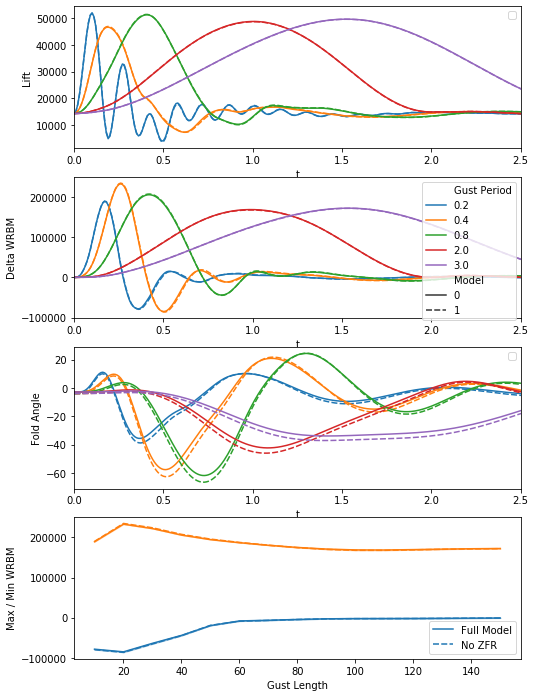

In [94]:
# compare locked and free for a given model
model = [0,1]
periods = [0.2,0.4,0.8,1.5,2,3]
data = GetReducedDataSet(df,model_num = model,GustPeriod=periods,Locked=['Free'])
datav2 = GetReducedDataSet(df,model_num = model,GustPeriod=None,Locked=['Free'])

fig, axes = plt.subplots(4,1,figsize=(8,12))

sns.lineplot(data = data, x = 't',y='Lift',hue = 'Gust Length',style = 'Model',ax = axes[0])
#sns.lineplot(data = data, x = 't',y='WRBM',hue = 'Gust Length',style = 'Locked',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Delta WRBM',hue = 'Gust Period',style = 'Model',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Fold Angle',hue = 'Gust Period',style = 'Model',ax = axes[2])

sns.lineplot(data = datav2, x='Gust Length',y='WRBM Min',style = 'Model',ax=axes[3])
sns.lineplot(data = datav2, x='Gust Length',y='WRBM Max',style = 'Model',ax=axes[3],legend=False)

for i in [0,1,2]:
    axes[i].set(xlim=(0,2.5))

axes[0].legend([])
axes[2].legend([])
axes[3].set_ylabel('Max / Min WRBM')
datav2['Gust Length'].unique()

axes[3].legend([model_names[i] for i in model])